In [1]:
#%reset -f 
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import pickle
import random
from datetime import datetime
from pathlib import Path
from scipy.signal import savgol_filter
from scipy.stats import zscore, median_abs_deviation
import pyarrow.parquet as pq 
import matplotlib.pyplot as plt
from itertools import groupby

from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):   # cells can be skipped by using '%%skip' in the first line
    return

In [2]:
# ------------ LOCATE REPOSITORY/DATASTORAGE IN CURRENT SYSTEM ENVIRONMENT  --------------
import sys, os; from pathlib import Path                                                #|
global ROOT, DATA_PATH, IS_NOTEBOOK; IS_NOTEBOOK = True                                 #|
ROOT = Path('..').resolve() if IS_NOTEBOOK else Path('.').resolve()                     #|
print(f"{'-'*60}\n{ROOT}:\t{', '.join([_.name for _ in ROOT.glob('*/')])}")             #|
sys.path.append(os.path.abspath(ROOT))                                                  #|
from data import get_data_path  # paths set in "data/__init__.py"                       #|
DATA_PATH = get_data_path()                                                             #|
print(f"{DATA_PATH}:\t\t{', '.join([_.name for _ in DATA_PATH.glob('*/')])}")           #|
# ----------------------------------------------------------------------------------------

------------------------------------------------------------
C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-eR-PINN:	.git, archive, data, project, ref, src, test
C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-Data:		ext, ext2, ext3, final, final_2, processed, TripSequences, trips_processed_final, trips_processed_pickles, trips_processed_resampled, y_true


In [3]:
# relative Imports: ---------------------------------------------------------------------------------------------------
from src.physics_model.VehModel import CreateVehicle
# FILE SOURCES UPDATED ---------------------------------------------------------------
trips_processed_final = Path(DATA_PATH, "TripSequences", "trips_processed_final") # Trip parquet files
trips_processed_resampled = Path(DATA_PATH, "TripSequences", "trips_processed_resampled") # Trip parquet files for resampled time series
trips_processed_pickles = Path(DATA_PATH, "TripSequences", "trips_processed_pickles") # Trip pickles data of PhysModel


In [4]:
# GET DIRECTORY CONTENS:
def get_files(folder, ext, full = False): return [file if full else file.name for file in folder.glob(f'*{ext}')]
trips = get_files(trips_processed_final, ".parquet", full = False)
len(trips)

18629

In [21]:
# get list of signals
df = pd.read_parquet(Path(trips_processed_final, trips[0]), engine='fastparquet')
all_columns = df.columns
assert len(all_columns) == 44

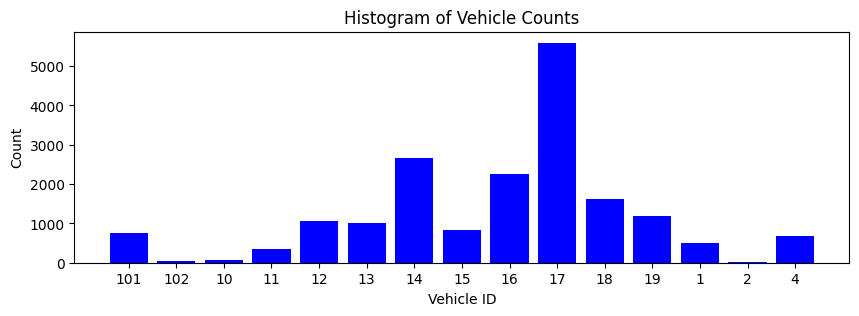

In [ ]:
from collections import Counter
vehicle_counts = Counter()

for trip in trips:
    vehicle_id = trip[1:4].strip("_TV."); file_code = trip[:10].strip(".parquet")
    #print(f"\tVehicle ID: {vehicle_id}, File Code: {file_code}")
    vehicle_counts[vehicle_id] += 1
vehicle_counts

# Plot histogram of vehicle counts
plt.figure(figsize=(10, 4))
plt.bar(vehicle_counts.keys(), vehicle_counts.values(), color='blue')
plt.xlabel('Vehicle ID')
plt.ylabel('Count')
plt.title('Histogram of Vehicle Counts')
plt.show()

In [ ]:
trip_lengths = []

for trip in trips:
    trip_rows = pq.read_metadata(Path(trips_processed_final, trip)).num_rows
    trip_lengths.append(trip_rows)


Mean Trip Length: 2529.936926297708
Max Trip Length: 20843
Min Trip Length: 110
Median Trip Length: 1272.0


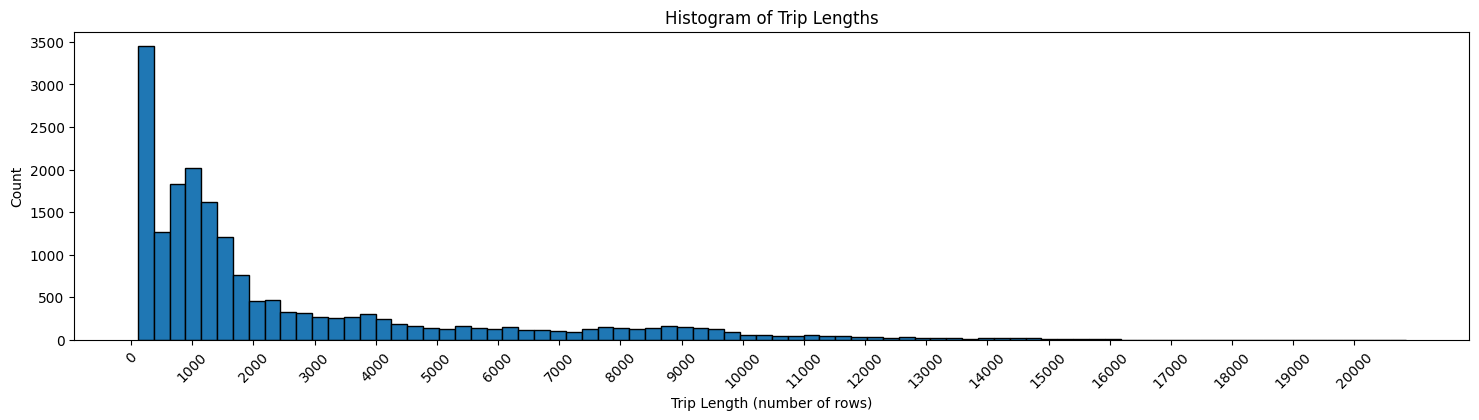

In [25]:

# Plot histogram of trip lengths
plt.figure(figsize=(18, 4))
plt.hist(trip_lengths, bins=80, edgecolor='black')
plt.xlabel('Trip Length (number of rows)')
plt.ylabel('Count')
plt.title('Histogram of Trip Lengths')
plt.xticks(ticks=np.arange(0, max(trip_lengths), step=1000), rotation=45)

# Calculate mean trip length
mean_trip_length = np.mean(trip_lengths)
max_trip_length = np.max(trip_lengths)
min_trip_length = np.min(trip_lengths)
median_trip_length = np.median(trip_lengths)

print(f"Mean Trip Length: {mean_trip_length}")
print(f"Max Trip Length: {max_trip_length}")
print(f"Min Trip Length: {min_trip_length}")
print(f"Median Trip Length: {median_trip_length}")

In [23]:
trip_distances = []

for trip in trips:
    df = pd.read_parquet(Path(trips_processed_final, trip), columns = ['hirestotalvehdist_cval_icuc'], engine='fastparquet')
    dist = df['hirestotalvehdist_cval_icuc']
    start_dist = dist.iloc[0]
    if start_dist > 1e6: print(trip)
    end_dist = dist.iloc[-1]
    trip_distances.append(end_dist)

Mean Trip d: 34.712276696194785 km
Max Trip d: 343.11999999999534 km
Min Trip d: 0.10999999999967258 km
Median Trip d: 13.066000000000713 km


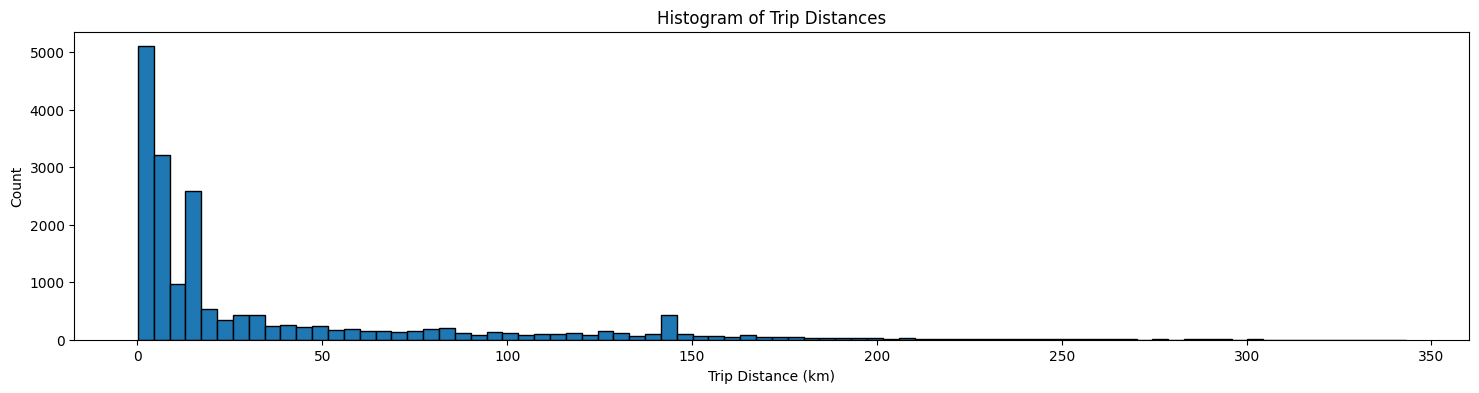

In [27]:
plt.figure(figsize=(18, 4))
plt.hist(trip_distances, bins=80, edgecolor='black')
plt.xlabel('Trip Distance (km)')
plt.ylabel('Count')
plt.title('Histogram of Trip Distances')

# Calculate mean trip length
mean_trip_length = np.mean(trip_distances)
max_trip_length = np.max(trip_distances)
min_trip_length = np.min(trip_distances)
median_trip_length = np.median(trip_distances)

print(f"Mean Trip d: {mean_trip_length} km")
print(f"Max Trip d: {max_trip_length} km")
print(f"Min Trip d: {min_trip_length} km")
print(f"Median Trip d: {median_trip_length} km")

In [ ]:
#####################################
value_ranges = {'vehspd_cval_cpc': (0, 110),    # set ranges
                'hv_batmomavldischrgen_cval_1': (2, 440),
                'altitude_cval_ippc': (-30, 2800),
                'roadgrad_cval_pt': (-20, 20),
                'longitude_cval_ippc': (-5, 35),
                'latitude_cval_ippc': (35, 68),
                'vehweight_cval_pt': (7, 44),
                'airtempoutsd_cval_cpc': (-30, 48),
                'actualtorque_pti1': (-100, 100),
                'elcomp_pwrcons_cval': (0, 14),
                'hv_bat_soc_cval_bms1': (4.9, 100),
                'hv_batavcelltemp_cval_bms1': (-10, 48),
                'epto_pwr_cval': (0, 20), 
                'currpwr_contendrnbrkresist_cval': (0, 90),
                'brc_stat_brc1': [1.0, 2.0, 3.0], # set values
                'selgr_rq_pt': [0.0, 1.0, 2.0]} # set values


out_of_range_files = []

for trip in trips:
    df = pd.read_parquet(Path(trips_processed_final, trip), engine='fastparquet')
    out_of_range_values = {}
    
    for column, value_range in value_ranges.items():
        if column in df.columns:
            if isinstance(value_range, tuple):
                out_of_range = df[(df[column] < value_range[0]) | (df[column] > value_range[1])]
            else:
                out_of_range = df[~df[column].isin(value_range)]
            
            if not out_of_range.empty:
                out_of_range_values[column] = out_of_range[column].tolist()
    
    if out_of_range_values:
        out_of_range_files.append((trip, out_of_range_values))

print("Files with values outside the specified ranges:")
for file, values in out_of_range_files:
    print(f"File: {file}")
    for column, out_values in values.items():
        print(f"  Column: {column}")
        print(f"  Values: {out_values}")

In [20]:
df.columns

Index(['altitude_cval_ippc', 'roadgrad_cval_pt', 'emot_pwr_cval',
       'vehspd_cval_cpc', 'latitude_cval_ippc'],
      dtype='object')

In [8]:
signal_dict

{'hirestotalvehdist_cval_icuc': {'mean': 0,
  'median': 0,
  'max': -inf,
  'min': inf,
  'count': 0,
  'std': 0,
  'nans': 0},
 'altitude_cval_ippc': {'mean': 354.74979264220985,
  'median': 339.9904053617687,
  'max': 2760.25,
  'min': -20.0,
  'count': 47130195,
  'std': 120.55090826624831,
  'nans': 0},
 'latitude_cval_ippc': {'mean': 47.710640417002,
  'median': 47.71014356579189,
  'max': 67.43178649999999,
  'min': 36.720080499999995,
  'count': 47130195,
  'std': 0.09513026171252037,
  'nans': 0},
 'longitude_cval_ippc': {'mean': 0,
  'median': 0,
  'max': -inf,
  'min': inf,
  'count': 0,
  'std': 0,
  'nans': 0},
 'accelpdlposn_cval': {'mean': 0,
  'median': 0,
  'max': -inf,
  'min': inf,
  'count': 0,
  'std': 0,
  'nans': 0},
 'actdrvtrnpwrprc_cval': {'mean': 0,
  'median': 0,
  'max': -inf,
  'min': inf,
  'count': 0,
  'std': 0,
  'nans': 0},
 'actualdcvoltage_pti1': {'mean': 0,
  'median': 0,
  'max': -inf,
  'min': inf,
  'count': 0,
  'std': 0,
  'nans': 0},
 'actuals

In [9]:
signal_unique_values
for signal in signal_unique_values:
    signal_unique_values[signal] = sorted(signal_unique_values[signal], reverse=True)
suv2=signal_unique_values
sd2=signal_dict

In [19]:
aa = suv2[in_check[4]]

In [10]:
sig = list(sd2.keys())[0]
print(sig)
all = suv2[sig]
print(sd2[sig])


hirestotalvehdist_cval_icuc
{'mean': 0, 'median': 0, 'max': -inf, 'min': inf, 'count': 0, 'std': 0, 'nans': 0}


In [51]:
import pandas as pd

# Convert the values in the list 'all' to datetime format
print(pd.to_datetime(min(all), unit='ns'))
print(pd.to_datetime(max(all), unit='ns'))

1970-01-19 19:53:25.050451001
2024-02-29 14:39:19.481001216


___

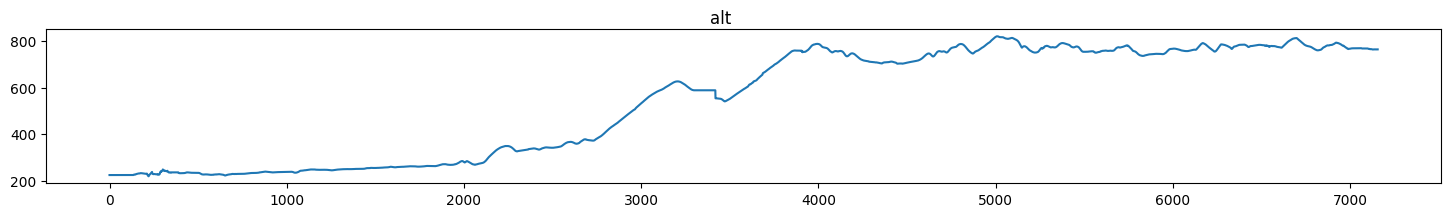

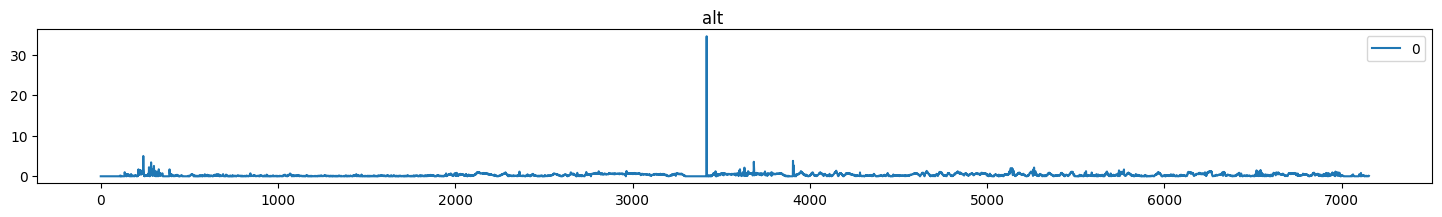

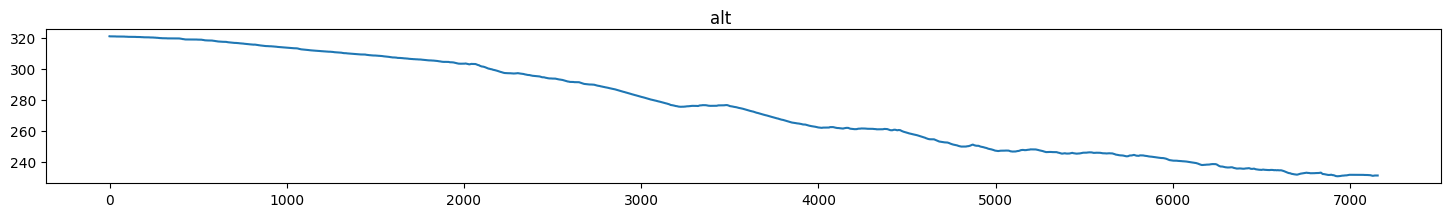

In [22]:

alt = df["altitude_cval_ippc"]
alt.plot(subplots=True, figsize=(18, 2), title="alt"); plt.show()
alt_diff = pd.DataFrame(abs(np.diff(df['altitude_cval_ippc'].ffill().bfill())))
alt_diff.plot(subplots=True, figsize=(18, 2), title="alt"); plt.show()
df["hv_batmomavldischrgen_cval_1"].plot(subplots=True, figsize=(18, 2), title="alt"); plt.show()

C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-Data\ext2\trips_processed_final\V16_T2060.parquet
172


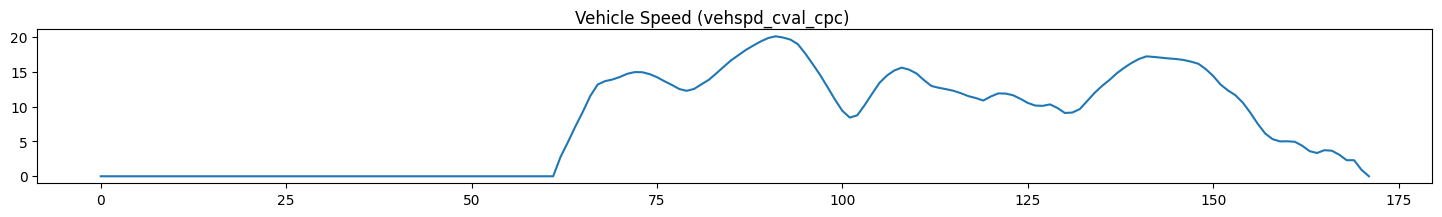

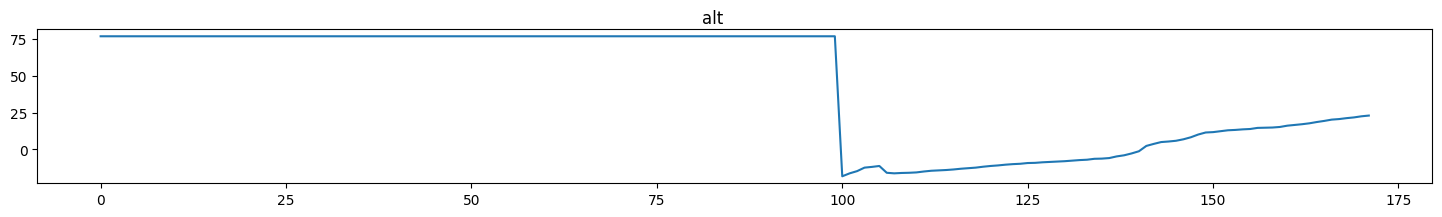

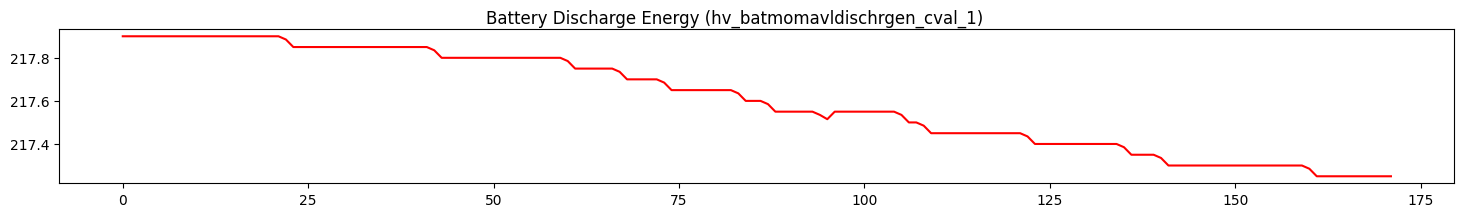

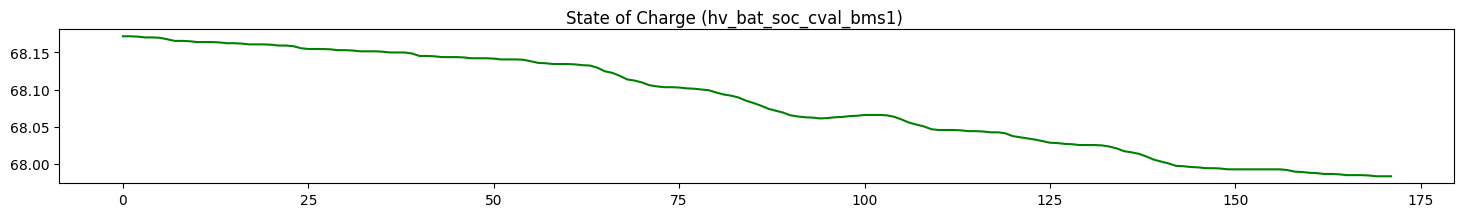

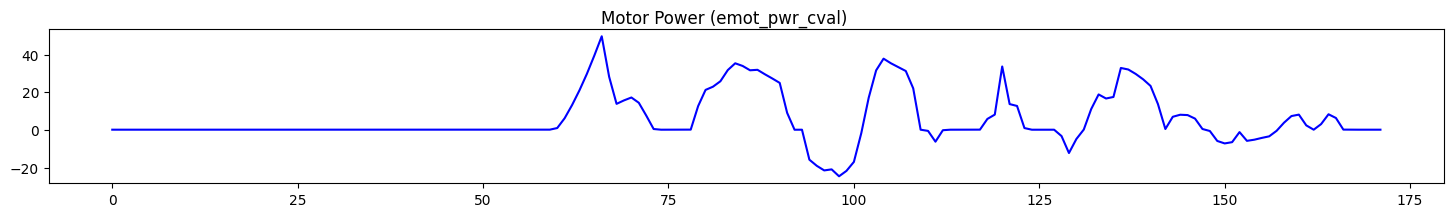

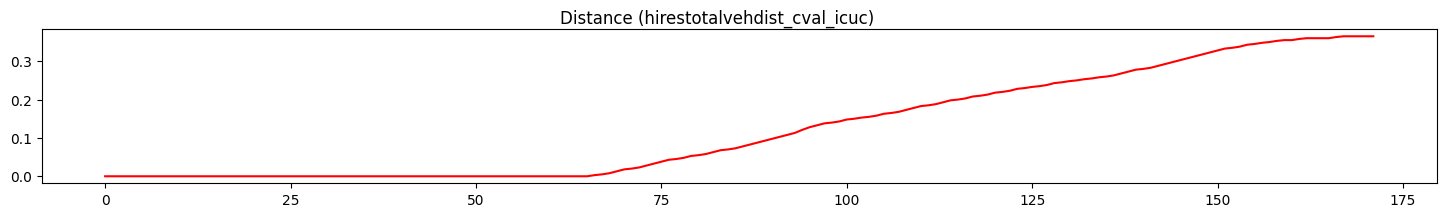

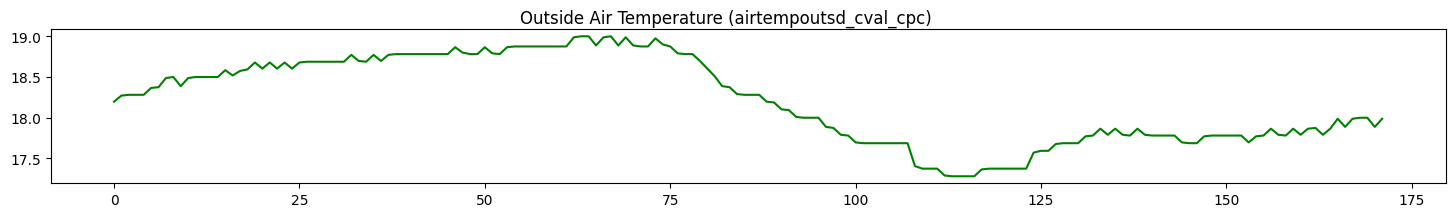

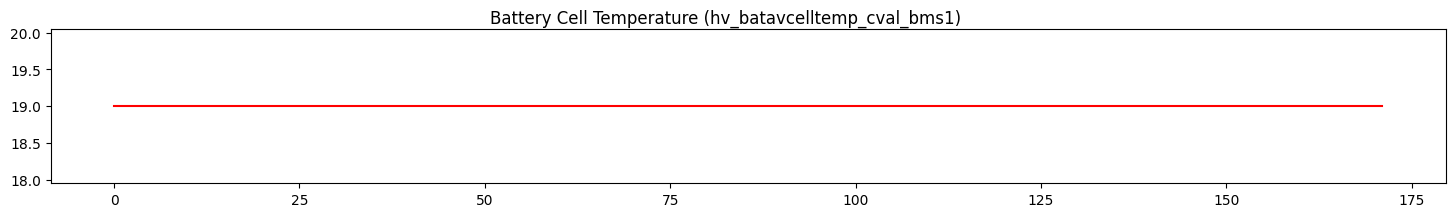

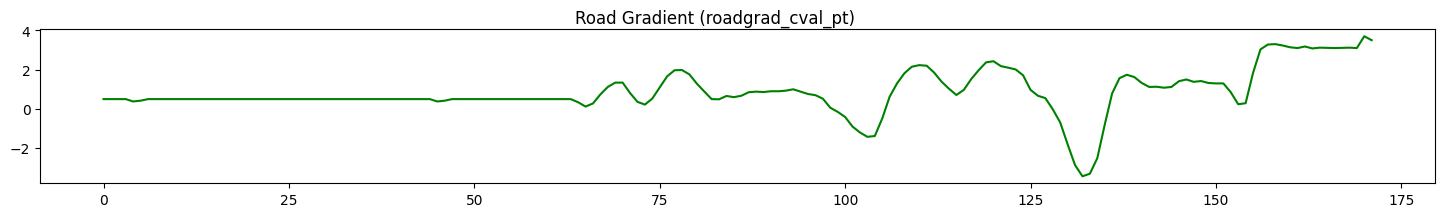

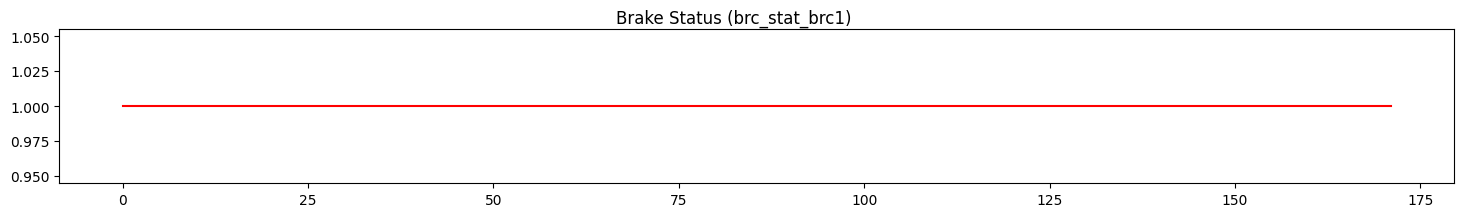

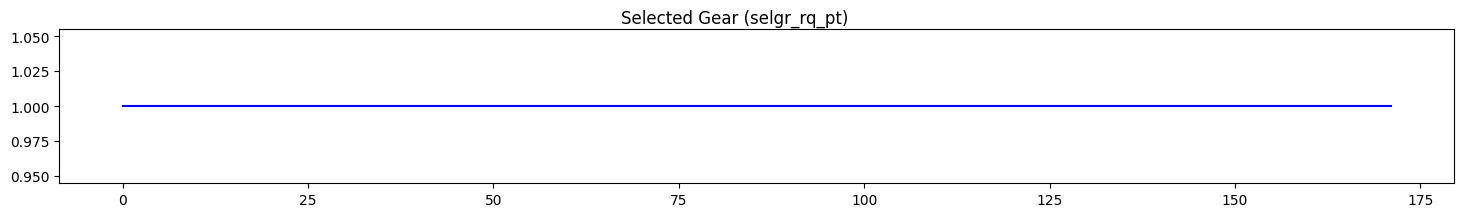

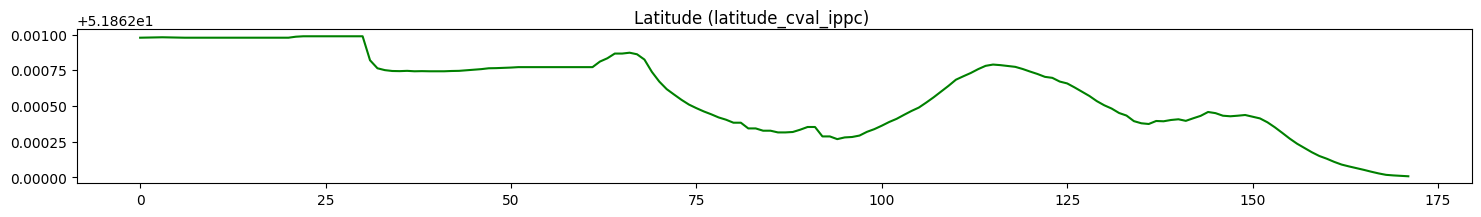

In [113]:
#samples = random.sample(trips, 1)
files = list(trips_processed_final.glob('*.parquet'))
samples = random.sample(files_with_exceed_indices, 1)
for i in samples:
    #i = 'V13_T813.parquet'

    file_path = Path(trips_processed_final, i)
    print(file_path)
    df = pd.read_parquet(file_path, engine='fastparquet')
    #df.reset_index(drop=True, inplace=True)
    print(len(df))

    v = df["vehspd_cval_cpc"]
    alt = df["altitude_cval_ippc"]
    alt_diff = pd.DataFrame(abs(np.diff(df['altitude_cval_ippc'].ffill().bfill())))
    en = df["hv_batmomavldischrgen_cval_1"]
    soc = df["hv_bat_soc_cval_bms1"]
    mot = df['emot_pwr_cval']
    dist = df["hirestotalvehdist_cval_icuc"]
    air2 = df["airtempoutsd_cval_cpc"]
    bata = df['hv_batavcelltemp_cval_bms1']
    roadg = df['roadgrad_cval_pt']
    brc = df['brc_stat_brc1']
    selgr = df['selgr_rq_pt']
    lat = df['latitude_cval_ippc']
    '''
    print(len(df))
    alt_diff = pd.DataFrame(abs(np.diff(df['altitude_cval_ippc'])))
    #alt_diff = alt_diff.fillna(0)
    print(alt_diff[0].max())
    exceed_indices = alt_diff[alt_diff[0] > 50].index.tolist()
    print(exceed_indices)
    if exceed_indices:
        print(exceed_indices[-1])
        df = df.loc[exceed_indices[-1]:]
        df.reset_index(drop=True, inplace=True)
        print(len(df))

    alt_diff = pd.DataFrame(abs(np.diff(df["altitude_cval_ippc"]))); print(alt_diff[0].max())
    lat_diff = pd.DataFrame(abs(np.diff(df["latitude_cval_ippc"]))); print(lat_diff[0].max())
    exceed_indices = alt_diff[alt_diff[0] > 100].index.union(lat_diff[lat_diff[0] > 10].index) # sudden altitude jumps of more than 50m or latitude jumps of more than 10 degrees
    exceed_indices = sorted(set(exceed_indices))  # remove duplicates and sort
    if exceed_indices:
        print(alt_diff[0].max())
        print(f"\t exceed indices: {exceed_indices}")
        print(f"\tAltitude jump of {alt_diff[0].iloc[exceed_indices[-1]]} detected at index {exceed_indices[-1]}")'''


    #en = df["hv_batmomavldischrgen_cval_1"].ffill().bfill()
    #en = df["hv_batmomavldischrgen_cval_1"].interpolate(method='spline', order=3)
    #en = df["hv_batmomavldischrgen_cval_1"].interpolate(method='polynomial', order=2)
    #print(df["hv_batmomavldischrgen_cval_1"].isna().mean())


    v.plot(subplots=True, figsize=(18, 2), title="Vehicle Speed (vehspd_cval_cpc)"); plt.show()
    alt.plot(subplots=True, figsize=(18, 2), title="alt"); plt.show()
    #alt_diff.plot(subplots=True, figsize=(18, 2), title="alt"); plt.show()
    en.plot(subplots=True, figsize=(18, 2), color='r', title="Battery Discharge Energy (hv_batmomavldischrgen_cval_1)"); plt.show()
    soc.plot(subplots=True, figsize=(18, 2), color='g', title="State of Charge (hv_bat_soc_cval_bms1)"); plt.show()
    mot.plot(subplots=True, figsize=(18, 2), color='b', title="Motor Power (emot_pwr_cval)"); plt.show()
    dist.plot(subplots=True, figsize=(18, 2), color='r', title="Distance (hirestotalvehdist_cval_icuc)"); plt.show()
    air2.plot(subplots=True, figsize=(18, 2), color='g', title="Outside Air Temperature (airtempoutsd_cval_cpc)"); plt.show()
    bata.plot(subplots=True, figsize=(18, 2), color='r', title="Battery Cell Temperature (hv_batavcelltemp_cval_bms1)"); plt.show()
    roadg.plot(subplots=True, figsize=(18, 2), color='g', title="Road Gradient (roadgrad_cval_pt)"); plt.show()
    brc.plot(subplots=True, figsize=(18, 2), color='r', title="Brake Status (brc_stat_brc1)"); plt.show()
    selgr.plot(subplots=True, figsize=(18, 2), color='b', title="Selected Gear (selgr_rq_pt)"); plt.show()
    lat.plot(subplots=True, figsize=(18, 2), color='g', title="Latitude (latitude_cval_ippc)"); plt.show()
    #plt.show()
    #brc.plot(subplots=True, figsize=(18, 2), color ='r'); plt.show()
    #selgr.plot(subplots=True, figsize=(18, 2), color ='b'); plt.show()
    #lat.plot(subplots=True, figsize=(18, 2), color ='g'); plt.show()
    #soc.plot(subplots=True, figsize=(18, 2), color ='r'); plt.show()
    #df["hv_batmomavldischrgen_cval_1"].plot(subplots=True, figsize=(18, 3), color ='r')
    #df["altitude_cval_ippc"].plot(subplots=True, figsize=(18, 3), color ='g')
    #df["bs_roadincln_cval"].plot(subplots=True, figsize=(18, 3), color ='g')
    #plt.show()


In [14]:
import pandas as pd
from pathlib import Path

# Function to check for NaN values in parquet files
def check_nan_files(folder_path):
    nan_files = []
    for file in folder_path.glob("*.parquet"):
        df = pd.read_parquet(file, engine='fastparquet')
        if df.isna().any().any():
            nan_files.append(file.name)
    return nan_files

# Define the folder paths
folders = [trips_processed_final, trips_processed_resampled]

# Check for NaN files in each folder
for folder in folders:
    nan_files = check_nan_files(folder)
    print(f"Files with NaN values in {folder}:")
    for file in nan_files:
        print(file)

Files with NaN values in C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-Data\ext2\trips_processed_final:
Files with NaN values in C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-Data\ext2\trips_processed_resampled:


In [ ]:
def check_nans_in_parquet_files(directories):
    files_with_nans = []

    for directory in directories:
        for file in directory.glob("*.parquet"):
            df = pd.read_parquet(file, engine='fastparquet')
            if df.isna().any().any():
                nan_columns = df.columns[df.isna().any()].tolist()
                files_with_nans.append((file, nan_columns))
                print(f"File {file} has NaNs in columns: {nan_columns}")

    return files_with_nans

directories = [Path(DATA_PATH, "final_2", "trips_processed_resampled"), Path(DATA_PATH, "final_2", "trips_processed_final")]
files_with_nans = check_nans_in_parquet_files(directories)

print("Files with NaNs:")
for file in files_with_nans:
    print(file)

In [ ]:
total_values_count = 0
trips = get_files(trips_processed_final, ".parquet", full=True)

for trip_file in trips:
    metadata = pq.read_metadata(Path(parquet_folder, trip_file))
    total_values_count += metadata.num_rows * metadata.num_columns

print(f"Total number of values in all trip files: {total_values_count}")
print(f"Average file length: {round(total_values_count / (len(trips) * metadata.num_columns))}")



In [ ]:

for trip_file in trips:
    df = pd.read_parquet(Path(parquet_folder, trip_file), engine='fastparquet')

    total_values_count += df.size

print(f"Total number of values in all trip files: {total_values_count}")

In [ ]:
import os

base_names = [os.path.basename(file[0]) for file in files_with_nans]
print(base_names)
[f for f in base_names if f not in remove_selection]


In [192]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3515 entries, 0 to 3514
Data columns (total 44 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   signal_time                      3515 non-null   datetime64[ns]
 1   hirestotalvehdist_cval_icuc      3515 non-null   float64       
 2   altitude_cval_ippc               3515 non-null   float64       
 3   latitude_cval_ippc               3515 non-null   float64       
 4   longitude_cval_ippc              3515 non-null   float64       
 5   accelpdlposn_cval                3515 non-null   float64       
 6   actdrvtrnpwrprc_cval             3515 non-null   float64       
 7   actualdcvoltage_pti1             3515 non-null   float64       
 8   actualspeed_pti1                 3515 non-null   float64       
 9   actualtorque_pti1                3515 non-null   float64       
 10  airtempinsd_cval_hvac            3515 non-null   float64    

In [ ]:
%%skip
def get_non_empty_columns(parquet_folder):
    # Initialize a set with all column names from the first file
    first_file = next(parquet_folder.glob("*.parquet"))
    df = pd.read_parquet(first_file, engine='fastparquet')
    non_empty_columns = set(df.columns)

    # Iterate through each file and update the set of non-empty columns
    for file in parquet_folder.glob("*.parquet"):
        df = pd.read_parquet(file, engine='fastparquet')
        non_empty_columns &= set(df.columns[df.notna().any()])

    return list(non_empty_columns)

non_empty_columns = get_non_empty_columns(parquet_folder)
print("Columns that are never empty in any file:")


In [ ]:
# empty_columns = [col for col in all_columns if col not in non_empty_columns and col not in sparse_signals]
empty_columns = ['cc_setspd_cval', 'minmoduletempindex_bms01', 'brc_stat_brc2', 'maxbrickvoltage_bms01', 'maxpwr_contendrnbrkresist2', 
'chargestate', 'actualtorque_pti2', 'dsrdpwr_contendrn2_cval', 'maproadgrad_cval', 'hv_batisores_cval_e2e', 'emot_pwr_cval', 'dsrdpwr_contendrn_cval', 
'grocmbvehweight_cval', 'actualtorque_pti1', 'brc_stat_brc1', 'pt4_dcb_hvdc_power_max_st3', 'hv_pwr_cval_dcl1', 'airtempoutsd_cval_cpc', 
'actdrvtrnpwrprc_cval', 'meanmoduletemperature_bms01', 'linkvoltage_bms05', 'hv_ptc_cabin1_pwr_cval', 'lv_conv_voltdmd_e2e_dcl1', 
'lv_convmaxcurr_cval_dcl1', 'hv_batlinkvoltage_sc01', 'hv_dclink_volt_cval_brc2', 'maxmoduletempindex_bms01', 'elcomp_pwrcons_cval', 
'lv_convcurr_cval_dcl1', 'oiltemp_ra_cval', 'pt4_dcb_temp1_st3', 'pt4_dcb_temp2_st3', 'hv_curr_cval_dcl1', 'hv_dclink_volt_cval_dcl1', 
'lv_conv_dc_momvolt_cval_dcl1', 'maxrecuppwrprc_cval', 'hv_ptc2_pwr_cval', 'currpwr_contendrnbrkresist2', 'lv_convpwr_cval_dcl1', 
'epto_pwr_cval', 'maxtracpwrpct_cval', 'currtmp_brkresist1int_cval', 'hv_dclink_volt_cval_brc', 'currpwr_contendrnbrkresist_cval', 
'maxpwr_contendrnbrkresist_cval', 'hv_bat_intres_cval_bms1', 'stringvoltage_bms01', 'currtmp_brkresist2int_cval', 'hv_bat_dc_volt_cval_bms1']


In [ ]:
%%skip
def find_files_with_all_nans(parquet_folder, empty_columns):
    result = {column: {"count": 0, "files": []} for column in empty_columns}
    
    for file in parquet_folder.glob("*.parquet"):
        print(file)
        df = pd.read_parquet(file, engine='fastparquet', columns=empty_columns)
        
        for column in empty_columns:
            if df[column].isna().all():
                result[column]["count"] += 1
                result[column]["files"].append(file.name)
    
    return result

nan_columns_files = find_files_with_all_nans(parquet_folder, empty_columns)

for column, info in nan_columns_files.items():
    print(f"Column: {column}")
    print(f"Number of files with all NaNs: {info['count']}")
    print(f"Files: {info['files']}\n")


In [ ]:
%%skip
collected_files = set()
collected_signals = []

for column, info in nan_columns_files.items():
    if info['count'] < 140:
        for file_name in info['files']:
            collected_files.add(file_name)
    else:
        collected_signals.append(column)

collected_files =[x for x in collected_files if x not in short_trips]
print(f"Collected parquet files: {len(collected_files)}")
for file in collected_files:
    print(file)

print(f"Collected signals: {len(collected_signals)}")
for signal in collected_signals:
    print(signal)

In [ ]:
# Results:
remove_selection = ['v_id983V2_trip5.parquet', 'v_id983V10_trip60.parquet', 'v_id983V2_trip19.parquet', 'v_id983V13_trip2.parquet', 
'v_id983V13_trip276_2.parquet', 'v_id983V14_trip2.parquet', 'v_id983V16_trip185.parquet', 'v_id983V11_trip15.parquet', 
'v_id983V10_trip27.parquet', 'v_id983V10_trip48.parquet', 'v_id983V1_trip8.parquet', 'v_id983V10_trip21.parquet', 'v_id983V16_trip304.parquet', 
'v_id983V2_trip37.parquet', 'v_id983V1_trip16.parquet', 'v_id983V1_trip16_2.parquet', 'v_id983V10_trip57.parquet', 'v_id983V16_trip190.parquet',
'v_id983V10_trip29_2.parquet', 'v_id983V16_trip197_2.parquet', 'v_id983V10_trip39.parquet', 'v_id983V10_trip49.parquet', 'v_id983V101_trip54.parquet', 
'v_id983V1_trip2_2.parquet', 'v_id983V10_trip4.parquet', 'v_id983V17_trip46.parquet', 'v_id983V101_trip175.parquet', 'v_id983V10_trip39_2.parquet',
'v_id983V11_trip16.parquet', 'v_id983V2_trip44.parquet', 'v_id983V10_trip61.parquet', 'v_id983V10_trip54.parquet', 'v_id983V16_trip188_2.parquet',
'v_id983V10_trip35.parquet', 'v_id983V10_trip16.parquet', 'v_id983V17_trip69.parquet', 'v_id983V17_trip1.parquet', 'v_id983V10_trip38.parquet', 
'v_id983V1_trip1.parquet', 'v_id983V10_trip52_2.parquet', 'v_id983V1_trip7.parquet', 'v_id983V10_trip23.parquet', 'v_id983V11_trip16_2.parquet',
'v_id983V16_trip184.parquet', 'v_id983V2_trip21.parquet', 'v_id983V2_trip15.parquet', 'v_id983V10_trip47.parquet', 'v_id983V2_trip12.parquet', 
'v_id983V2_trip3_2.parquet', 'v_id983V16_trip180.parquet', 'v_id983V2_trip25.parquet', 'v_id983V2_trip7.parquet', 'v_id983V16_trip179.parquet',
'v_id983V2_trip27.parquet', 'v_id983V2_trip13.parquet', 'v_id983V2_trip3.parquet', 'v_id983V17_trip70.parquet', 'v_id983V11_trip13_2.parquet',
'v_id983V1_trip9_2.parquet', 'v_id983V10_trip26_2.parquet', 'v_id983V10_trip24.parquet', 'v_id983V10_trip29.parquet', 'v_id983V2_trip17.parquet',
'v_id983V10_trip55.parquet', 'v_id983V10_trip14.parquet', 'v_id983V16_trip178.parquet', 'v_id983V10_trip58.parquet', 'v_id983V2_trip39.parquet',
'v_id983V16_trip183.parquet', 'v_id983V10_trip37.parquet', 'v_id983V10_trip5.parquet', 'v_id983V10_trip20_2.parquet', 'v_id983V2_trip32.parquet',
'v_id983V16_trip188.parquet', 'v_id983V2_trip36.parquet', 'v_id983V10_trip25.parquet', 'v_id983V2_trip30.parquet', 'v_id983V11_trip14_2.parquet',
'v_id983V2_trip20.parquet', 'v_id983V2_trip38.parquet', 'v_id983V16_trip184_2.parquet', 'v_id983V1_trip11.parquet', 'v_id983V10_trip55_2.parquet',
'v_id983V10_trip5_2.parquet', 'v_id983V10_trip37_2.parquet', 'v_id983V2_trip39_2.parquet', 'v_id983V10_trip3.parquet',
'v_id983V10_trip60_2.parquet', 'v_id983V10_trip2.parquet', 'v_id983V2_trip16.parquet', 'v_id983V2_trip24.parquet', 'v_id983V2_trip18.parquet', 
'v_id983V10_trip59.parquet', 'v_id983V16_trip182.parquet', 'v_id983V1_trip6_2.parquet', 'v_id983V10_trip42.parquet', 'v_id983V2_trip44_2.parquet',
'v_id983V10_trip18.parquet', 'v_id983V17_trip2.parquet', 'v_id983V16_trip3.parquet', 'v_id983V2_trip36_2.parquet', 'v_id983V10_trip10.parquet', 
'v_id983V16_trip192.parquet', 'v_id983V2_trip35.parquet', 'v_id983V13_trip5.parquet', 'v_id983V2_trip10.parquet', 'v_id983V1_trip9.parquet', 
'v_id983V10_trip6.parquet', 'v_id983V10_trip44.parquet', 'v_id983V19_trip2_2.parquet', 'v_id983V16_trip186.parquet', 'v_id983V10_trip15.parquet',
'v_id983V19_trip4.parquet', 'v_id983V11_trip13.parquet', 'v_id983V16_trip196.parquet', 'v_id983V2_trip33.parquet', 'v_id983V16_trip191.parquet',
'v_id983V1_trip2.parquet', 'v_id983V10_trip41.parquet', 'v_id983V16_trip193.parquet', 'v_id983V2_trip11.parquet', 'v_id983V17_trip5.parquet',
'v_id983V10_trip17.parquet', 'v_id983V1_trip15.parquet', 'v_id983V10_trip9.parquet', 'v_id983V2_trip4.parquet', 'v_id983V10_trip42_2.parquet',
'v_id983V10_trip52.parquet', 'v_id983V4_trip86.parquet', 'v_id983V10_trip40.parquet', 'v_id983V10_trip28.parquet',
'v_id983V10_trip14_2.parquet', 'v_id983V2_trip23.parquet', 'v_id983V16_trip181.parquet', 'v_id983V1_trip4.parquet', 
'v_id983V10_trip7.parquet', 'v_id983V1_trip34.parquet', 'v_id983V19_trip1.parquet', 'v_id983V2_trip34.parquet', 'v_id983V10_trip43.parquet',
'v_id983V16_trip187.parquet', 'v_id983V17_trip4.parquet', 'v_id983V13_trip276.parquet', 'v_id983V10_trip26.parquet', 
'v_id983V16_trip180_2.parquet', 'v_id983V16_trip195.parquet', 'v_id983V11_trip14.parquet', 'v_id983V16_trip197.parquet',
'v_id983V13_trip1.parquet', 'v_id983V1_trip12.parquet', 'v_id983V10_trip56.parquet', 'v_id983V10_trip59_2.parquet',
'v_id983V2_trip8.parquet', 'v_id983V2_trip1.parquet', 'v_id983V2_trip22_2.parquet', 'v_id983V1_trip10.parquet', 'v_id983V2_trip42.parquet', 
'v_id983V2_trip15_2.parquet', 'v_id983V10_trip57_2.parquet', 'v_id983V10_trip49_2.parquet', 'v_id983V10_trip8.parquet',
'v_id983V10_trip50.parquet', 'v_id983V4_trip79.parquet', 'v_id983V16_trip194.parquet', 'v_id983V2_trip2.parquet',
'v_id983V10_trip13_2.parquet', 'v_id983V13_trip4.parquet', 'v_id983V17_trip6.parquet', 'v_id983V2_trip24_2.parquet', 
'v_id983V2_trip9.parquet', 'v_id983V16_trip185_2.parquet', 'v_id983V10_trip13.parquet', 'v_id983V2_trip14.parquet', 
'v_id983V2_trip22.parquet', 'v_id983V19_trip2.parquet', 'v_id983V2_trip6.parquet']

collected_signals = ['brc_stat_brc2', 'maxpwr_contendrnbrkresist2', 'dsrdpwr_contendrn2_cval', 'maproadgrad_cval',
'dsrdpwr_contendrn_cval', 'brc_stat_brc1', 'meanmoduletemperature_bms01', 'linkvoltage_bms05', 'hv_dclink_volt_cval_brc2',
'oiltemp_ra_cval', 'hv_ptc2_pwr_cval', 'currpwr_contendrnbrkresist2', 'epto_pwr_cval', 'currtmp_brkresist1int_cval', 
'hv_dclink_volt_cval_brc', 'currpwr_contendrnbrkresist_cval', 'maxpwr_contendrnbrkresist_cval', 'currtmp_brkresist2int_cval', 'hv_bat_dc_volt_cval_bms1']
len(remove_selection), len(collected_signals)

In [ ]:
def check_all_nan_columns(parquet_folder, remove_selection):
    files_with_all_nan_columns = []

    for file_name in remove_selection:
        file_path = Path(parquet_folder, file_name)
        df = pd.read_parquet(file_path, engine='fastparquet')
        columns_to_check = [col for col in df.columns if col not in drop_signals]
        all_nan_columns = df[columns_to_check].columns[df[columns_to_check].isna().all()].tolist()
        
        if all_nan_columns:
            files_with_all_nan_columns.append((file_name, all_nan_columns))
            print(f"File {file_name} has all-NaN columns: {all_nan_columns}")

    return files_with_all_nan_columns

files_with_all_nan_columns = check_all_nan_columns(parquet_folder, trips)

In [ ]:
def find_files_with_all_nans(parquet_folder, empty_columns):
    result = {column: {"count": 0, "files": []} for column in empty_columns}
    
    for file in parquet_folder.glob("*.parquet"):
        df = pd.read_parquet(file, engine='fastparquet', columns=empty_columns)
        
        for column in empty_columns:
            if df[column].isna().any() and df[column].isna().all():
                result[column]["count"] += 1
                result[column]["files"].append(file.name)
    
    return result

nan_columns_files = find_files_with_all_nans(parquet_folder, ['hv_bat_dc_volt_cval_bms1'])

for column, info in nan_columns_files.items():
    print(f"Column: {column}")
    print(f"Number of files with all NaNs: {info['count']}")
    print(f"Files: {info['files']}\n")

In [ ]:
collected_signals = ['brc_stat_brc2', 'maxpwr_contendrnbrkresist2', 'dsrdpwr_contendrn2_cval', 'maproadgrad_cval',
    'dsrdpwr_contendrn_cval', 'brc_stat_brc1', 'meanmoduletemperature_bms01', 'linkvoltage_bms05', 'hv_dclink_volt_cval_brc2',
    'oiltemp_ra_cval', 'hv_ptc2_pwr_cval', 'currpwr_contendrnbrkresist2', 'epto_pwr_cval', 'currtmp_brkresist1int_cval', 
    'hv_dclink_volt_cval_brc', 'currpwr_contendrnbrkresist_cval', 'maxpwr_contendrnbrkresist_cval', 'currtmp_brkresist2int_cval', 'hv_bat_dc_volt_cval_bms1']

In [ ]:
empty_columns = ['cc_setspd_cval', 'minmoduletempindex_bms01', 'brc_stat_brc2', 'maxbrickvoltage_bms01', 'maxpwr_contendrnbrkresist2', 
'chargestate', 'actualtorque_pti2', 'dsrdpwr_contendrn2_cval', 'maproadgrad_cval', 'hv_batisores_cval_e2e', 'emot_pwr_cval', 'dsrdpwr_contendrn_cval', 
'grocmbvehweight_cval', 'actualtorque_pti1', 'brc_stat_brc1', 'pt4_dcb_hvdc_power_max_st3', 'hv_pwr_cval_dcl1', 'airtempoutsd_cval_cpc', 
'actdrvtrnpwrprc_cval', 'meanmoduletemperature_bms01', 'linkvoltage_bms05', 'hv_ptc_cabin1_pwr_cval', 'lv_conv_voltdmd_e2e_dcl1', 
'lv_convmaxcurr_cval_dcl1', 'hv_batlinkvoltage_sc01', 'hv_dclink_volt_cval_brc2', 'maxmoduletempindex_bms01', 'elcomp_pwrcons_cval', 
'lv_convcurr_cval_dcl1', 'oiltemp_ra_cval', 'pt4_dcb_temp1_st3', 'pt4_dcb_temp2_st3', 'hv_curr_cval_dcl1', 'hv_dclink_volt_cval_dcl1', 
'lv_conv_dc_momvolt_cval_dcl1', 'maxrecuppwrprc_cval', 'hv_ptc2_pwr_cval', 'currpwr_contendrnbrkresist2', 'lv_convpwr_cval_dcl1', 
'epto_pwr_cval', 'maxtracpwrpct_cval', 'currtmp_brkresist1int_cval', 'hv_dclink_volt_cval_brc', 'currpwr_contendrnbrkresist_cval', 
'maxpwr_contendrnbrkresist_cval', 'hv_bat_intres_cval_bms1', 'stringvoltage_bms01', 'currtmp_brkresist2int_cval', 'hv_bat_dc_volt_cval_bms1']

In [ ]:
# signals more important than missing trips
required = ["cc_setspd_cval", "maxbrickvoltage_bms01", "actualtorque_pti1", "actualtorque_pti2", "hv_batisores_cval_e2e", "emot_pwr_cval", "grocmbvehweight_cval", "pt4_dcb_hvdc_power_max_st3",
            "pt4_dcb_temp1_st3", "pt4_dcb_temp2_st3", "hv_pwr_cval_dcl1", "airtempoutsd_cval_cpc", "actdrvtrnpwrprc_cval", "hv_ptc_cabin1_pwr_cval", "elcomp_pwrcons_cval",
            "hv_curr_cval_dcl1", "hv_dclink_volt_cval_dcl1", "maxrecuppwrprc_cval", 'lv_convpwr_cval_dcl1', 'maxtracpwrpct_cval', 'hv_bat_dc_volt_cval_bms1']

# trips more important so signals can be removed:
remove = ["minmoduletempindex_bms01", "maxmoduletempindex_bms01", "brc_stat_brc2", "maxpwr_contendrnbrkresist2","currtmp_brkresist2int_cval", "currpwr_contendrnbrkresist2",
 "chargestate", "dsrdpwr_contendrn2_cval","maproadgrad_cval", "airtempoutsd_cval_sca", "meanmoduletemperature_bms01", "linkvoltage_bms05", "lv_conv_voltdmd_e2e_dcl1",
  "lv_convmaxcurr_cval_dcl1", "lv_convcurr_cval_dcl1","lv_conv_dc_momvolt_cval_dcl1", "hv_batlinkvoltage_sc01", "hv_dclink_volt_cval_brc", "hv_dclink_volt_cval_brc2",
   "oiltemp_ra_cval", "hv_ptc2_pwr_cval","hv_bat_intres_cval_bms1", "stringvoltage_bms01", "currtmp_brkresist1int_cval", "maxpwr_contendrnbrkresist_cval"]

in_question = ["hv_bat_dc_momvolt_cval_bms1"]

In [ ]:
sample = random.choice(trips)
#sample = 'v_id983V10_trip13_2.parquet'
print(sample)
df = pd.read_parquet(Path(DATA_PATH, "processed", sample), engine='fastparquet')
_ = df["airtempoutsd_cval_cpc"].plot(figsize=(18, 4), subplots=True, color='r')
_ = df['ambtemp_cval_pt'].plot(figsize=(18, 3), subplots=True, color='g')
_ = pd.DataFrame(df["hv_curr_cval_dcl1"]).plot(figsize=(18, 3), subplots=True, color='b')

_ = pd.DataFrame(df["airtempoutsd_cval_cpc"] - df["airtempoutsd_cval_sca"]).plot(figsize=(18, 3), subplots=True)
#print((df['lv_conv_dc_momvolt_cval_dcl1'] * df['lv_convcurr_cval_dcl1'] * 1e-3).mean())
print((df["hv_bat_intres_cval_bms1"]).mean())

In [ ]:
df["hv_bat_dc_momvolt_cval_bms1"].isna().all()

In [ ]:
sample = random.choice(info['files'])
df = pd.read_parquet(Path(DATA_PATH, "processed", sample), engine='fastparquet')
#_ = df['actdrvtrnpwrprc_cval'].plot(figsize=(18, 4), subplots=True, color='r')
_ = df['epto_pwr_cval'].plot(figsize=(18, 4), subplots=True)

In [ ]:
collected_files = set()
collected_signals = []

for column, info in nan_columns_files.items():
    if info['count'] < 140:
        for file_name in info['files']:
            collected_files.add(file_name)
    else:
        collected_signals.append(column)

collected_files =[x for x in collected_files if x not in short_trips]
print(f"Collected parquet files: {len(collected_files)}")
for file in collected_files:
    print(file)

print(f"Collected signals: {len(collected_signals)}")
for signal in collected_signals:
    print(signal)

In [ ]:
# Extract mean velocity from each file
mean_velocities = []
dist = []
for file in files:
    df = pd.read_parquet(file, columns = ['vehspd_cval_cpc',"hirestotalvehdist_cval_icuc"], engine='fastparquet')
    mean_velocity = df['vehspd_cval_cpc'].mean()
    d_dist = df["hirestotalvehdist_cval_icuc"].max() - df["hirestotalvehdist_cval_icuc"].min()
    dist.append(d_dist)
    mean_velocities.append(mean_velocity)

# Plot histogram
plt.figure(figsize=(12, 4))
plt.hist(dist, bins=30, edgecolor='black')
plt.xlabel('Driven Distance')
plt.ylabel('Count')
plt.title('Histogram of Distances')
plt.grid(True)
plt.show()


dist = [d for d in dist if d <= 1000]
plt.figure(figsize=(12, 4))
plt.hist(dist, bins=30, edgecolor='black')
plt.xlabel('Driven Distance [km]')
plt.ylabel('Count')
plt.title('Histogram of Distances')
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=14)  # Increase tick numbers size
plt.show()